## Working with `ipyparallel`
In this example we want to use basico from ipython, in a `ipyparallel`, as the normal approach with using `multiprocessing` does not seem to work across operating systems within the jupyter notebooks (read: i could not make it work on Windows). 

This means, that to run this example, you will need the `ipyparallel` package installed, which can be achieved by uncommenting the folling line: 

In [1]:
#!pip install -q ipyparallel

once that is installed, you will to switch to the home screen of the jupyter notebook, and start the cluster manually: 

![Start the ipyparallel cluster](https://p194.p3.n0.cdn.getcloudapp.com/items/BluzKKej/bb46e13e-76ed-4d9b-ae58-7db8a4f5e599.gif?v=c09fdcbb6b6054085bb56b8f22f402e0)

otherwise this notebook will fail with an error like: 

    ---------------------------------------------------------------------------
    FileNotFoundError                         Traceback (most recent call last)
    Cell In[3], line 1
    ----> 1 cluster = ipp.Cluster.from_file()
          2 rc = cluster.connect_client_sync()
          3 # wait to get the engines and print their id

    File ~/env/lib/python3.11/site-packages/ipyparallel/cluster/cluster.py:556, in Cluster.from_file(cls, cluster_file, profile, profile_dir, cluster_id, **kwargs)
        554 # ensure from_file preserves cluster_file, even if it moved
        555 kwargs.setdefault("cluster_file", cluster_file)
    --> 556 with open(cluster_file) as f:
        557     return cls.from_dict(json.load(f), **kwargs)

    FileNotFoundError: [Errno 2] No such file or directory: 
    '~/.ipython/profile_default/security/cluster-.json'


Once the ipyparallel is installed and the cluster is running continue as follows: 

In [2]:
from basico import *
import ipyparallel as ipp

we could create a cluster manually, in my case i just created one in the cluster menu in the jupyter setup, so to access it we just need to run: 

In [3]:
cluster = ipp.Cluster.from_file()
rc = cluster.connect_client_sync()
# wait to get the engines and print their id
rc.wait_for_engines(6); rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

Now we create a direct view with all of the workers:

In [4]:
dview = rc[:]

The model we use is the BioModel 68, since we will need the model many times, i download it once and save it to a local file: 

In [5]:
m = load_biomodel(68)
save_model('bm68.cps', model=m)
remove_datamodel(m)

And define the worker method, the worker just loads a biomodel (in case it was not loaded into the worker before, otherwise it accesses the current model). It then chooses a random initial concentration for 2 species, and computes the steady state of the model. Finally the initial concentrations used and the fluxes computed are return. In case a `seed` is specified, it will be used to initialize the rng:

In [6]:
def worker_method(seed=None):
    import basico
    import random 
    if seed is not None:
        random.seed(seed)
    if basico.get_num_loaded_models() == 0:
        m = basico.load_model('bm68.cps')
    else: 
        m = basico.get_current_model()
        
    # we sample the model as described in Mendes (2009)
    cysteine = 0.3 * 10 ** random.uniform(0, 3)
    adomed = random.uniform(0, 100)    
    
    # set the sampled initial concentration. 
    basico.set_species('Cysteine', initial_concentration=cysteine, model=m)
    basico.set_species('S-adenosylmethionine', initial_concentration=adomed, model=m)

    # compute the steady state
    _ = basico.run_steadystate(model=m)

    # retrieve the current flux values
    fluxes = basico.get_reactions(model=m).flux

    # and return as tuple
    return (cysteine, adomed, fluxes[1], fluxes[2])
    

We can invoke this method synchronusly in the notebook to obtain the result:

In [7]:
worker_method()

(1.5236813977490542,
 29.805870872058716,
 0.04158430196391732,
 0.9584156980360827)

now we want to do that many times over (passing along the index to set the seed every time to get about the same result on my machine):

In [8]:
%%time
sync_results = []
for i in range(2000):
    sync_results.append(worker_method(i))

CPU times: user 2.06 s, sys: 55 ms, total: 2.12 s
Wall time: 2.08 s


here a utility method plotting the result: 

In [9]:
def plot_result(results):
    cys = [x[0] for x in results]
    ado = [x[1] for x in results]
    y1 = [x[2] for x in results]
    y2 = [x[3] for x in results]
    plt.plot(ado, y1, 'x')
    plt.plot(ado, y2, 'o')
    plt.show()

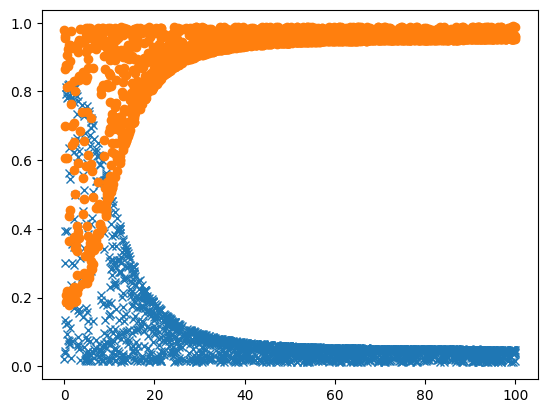

In [10]:
plot_result(sync_results)

So that for me took some 10 seconds (even though the model was loaded already), 
so the next thing to do is to run it in parallel. Here i start 10000 runs, passing along the seed for each one, to make it reproducible: 

In [11]:
%%time
ar_map = dview.map_async(worker_method, [i for i in range(10000)])
ar_map.wait_for_output()

CPU times: user 412 ms, sys: 259 ms, total: 671 ms
Wall time: 3.72 s


True

And now we can plot that as well: 

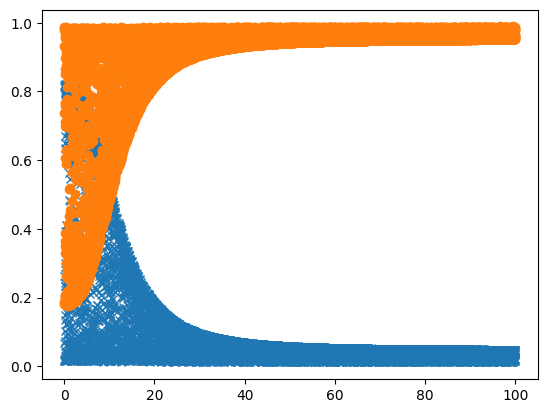

In [12]:
plot_result(ar_map.get())